# Modeling Non-Linear Patterns with Activation Functions


- Prepare the combined bike and car delivery data, this time applying a technique called **normalization** to help your model train more effectively.
- Build a non-linear neural network using the **ReLU** activation function.
- Train your new model to learn the complex, curved relationship in the data.
- Predict delivery times using your new model and see if it can finally succeed where the linear one failed.


## Imports


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils.helper_utils import (
    plot_data,
    plot_final_fit,
    plot_training_progress,
)

## Preparing the Non-Linear Data


In [2]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor(
    [
        [1.0],
        [1.5],
        [2.0],
        [2.5],
        [3.0],
        [3.5],
        [4.0],
        [4.5],
        [5.0],
        [5.5],
        [6.0],
        [6.5],
        [7.0],
        [7.5],
        [8.0],
        [8.5],
        [9.0],
        [9.5],
        [10.0],
        [10.5],
        [11.0],
        [11.5],
        [12.0],
        [12.5],
        [13.0],
        [13.5],
        [14.0],
        [14.5],
        [15.0],
        [15.5],
        [16.0],
        [16.5],
        [17.0],
        [17.5],
        [18.0],
        [18.5],
        [19.0],
        [19.5],
        [20.0],
    ],
    dtype=torch.float32,
)

# Corresponding delivery times in minutes
times = torch.tensor(
    [
        [6.96],
        [9.67],
        [12.11],
        [14.56],
        [16.77],
        [21.7],
        [26.52],
        [32.47],
        [37.15],
        [42.35],
        [46.1],
        [52.98],
        [57.76],
        [61.29],
        [66.15],
        [67.63],
        [69.45],
        [71.57],
        [72.8],
        [73.88],
        [76.34],
        [76.38],
        [78.34],
        [80.07],
        [81.86],
        [84.45],
        [83.98],
        [86.55],
        [88.33],
        [86.83],
        [89.24],
        [88.11],
        [88.16],
        [91.77],
        [92.27],
        [92.13],
        [90.73],
        [90.39],
        [92.98],
    ],
    dtype=torch.float32,
)

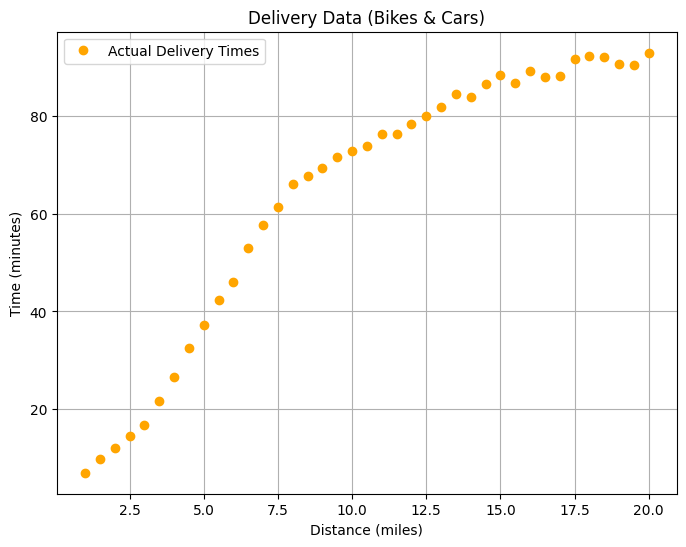

In [3]:
# Plot data
plot_data(distances, times)

## A New Step: Normalizing the Data


Normalization is a standard technique that makes the training process more stable and effective by adjusting the scale of the data. This adjustment helps prevent large distance values from dominating the learning process and keeps gradients stable during training.

- Calculate the mean and standard deviation for the `distances` and `times` tensors.
- Apply standardization to each tensor using its respective mean and standard deviation, which creates new normalized tensors named `distances_norm` and `times_norm`.


In [4]:
# Calculate the mean and standard deviation for the `distances` tensor
distances_mean = distances.mean()
distances_std = distances.std()

# Calculate the mean and standard deviation for the `times` tensor
times_mean = times.mean()
times_std = times.std()

# Apply standardization to the distances
distances_norm = (distances - distances_mean) / distances_std

# Apply standardization to the times
times_norm = (times - times_mean) / times_std

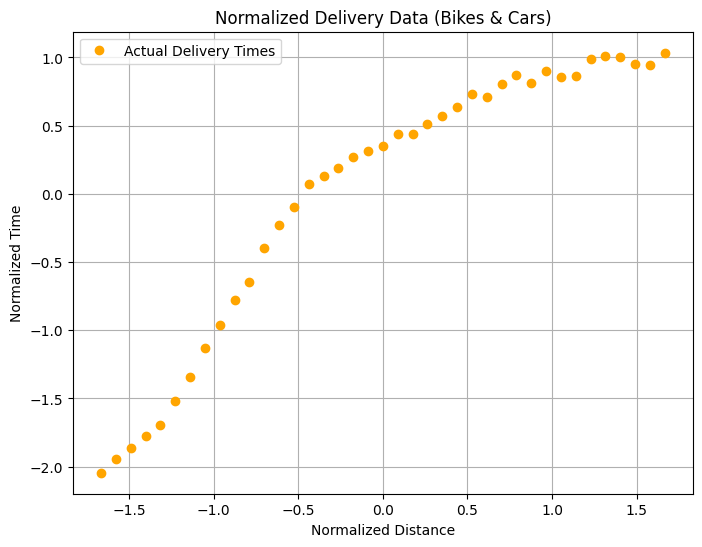

In [5]:
# Plot scaled data
plot_data(distances_norm, times_norm, normalize=True)

## Building the Non-Linear Model


- `nn.Linear(1, 3)`: This is your first hidden layer. It consists of three neurons each receiving one input feature (the normalized distance). This layer transforms the single input value into three separate values.
- `nn.ReLU()`: Applies the ReLU activation function to the output of each of the three neurons from the hidden layer. This is the crucial non-linear step that allows your model to create "bends" and learn curves instead of just straight lines.
- `nn.Linear(3, 1)`: This is your output layer. It takes the three activated values from the previous step as its input and combines them to produce a single final output, which is your predicted (normalized) delivery time.


In [6]:
# Ensures that your results are reproducible and consistent every time
torch.manual_seed(27)

model = nn.Sequential(nn.Linear(1, 3), nn.ReLU(), nn.Linear(3, 1))

## Training


In [7]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

With the model and training tools ready, it's time to begin the training process.


In [8]:
# Training loop
for epoch in range(3000):
    # Reset the optimizer's gradients
    optimizer.zero_grad()

    # Make predictions (forward pass)
    outputs = model(distances_norm)

    # Calculate the loss
    loss = loss_function(outputs, times_norm)

    # Calculate adjustments (backward pass)
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    # Create a live plot every 50 epochs
    # if (epoch + 1) % 50 == 0:
    #     plot_training_progress(
    #         epoch=epoch, loss=loss, model=model, distances_norm=distances_norm, times_norm=times_norm
    #     )

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")


Training Complete.

Final Loss: 0.00314371008425951


## Checking the Final Fit


Visualize your model's final predicted curve against the original data points


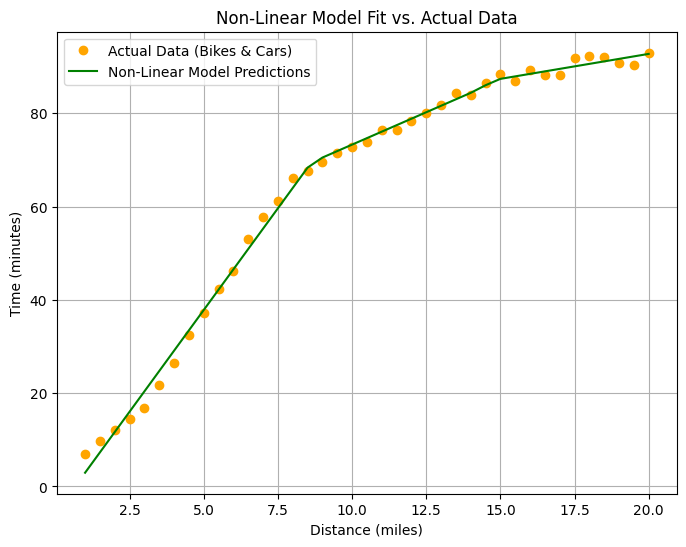

In [9]:
plot_final_fit(model, distances, times, distances_norm, times_std, times_mean)

## Making a Prediction


- Take the new input distance and **normalize** it using the same mean and standard deviation from our training data. This step is CRITICAL: your model has no idea about the original scales, it only understands the normalized scaled it was trained on.
- After the model provides its prediction, you must **de-normalize** the output. This converts the prediction from its normalized scaled back into an understandable value in minutes.


In [ ]:
distance_to_predict = 5.1

# Use the torch.no_grad() context manager for efficient prediction
with torch.no_grad():
    # Normalize the input distance
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean) / distances_std

    # Get the normalized prediction from the model
    predicted_time_norm = model(new_distance_norm)

    # De-normalize the output to get the actual time in minutes
    predicted_time_actual = (predicted_time_norm * times_std) + times_mean

    # --- Decision Making Logic ---
    print(
        f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes"
    )

    # First, check if the delivery is possible within the 45-minute timeframe
    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes.")
    else:
        # If it is possible, then determine the vehicle based on the distance
        if distance_to_predict <= 3:
            print(
                f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike."
            )
        else:
            print(
                f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (> 3 miles), use a car."
            )

Prediction for a 5.1-mile delivery: 38.7 minutes

Decision: Yes, delivery is possible. Since the distance is 5.1 miles (> 3 miles), use a car.
